In [6]:
include("../src/shared.jl")
max_it = 100;

solver_dic = Dict(
"One Phase" => OnePhase.OnePhaseSolver(term!max_it= max_it, output_level=0),
# turn off acceptable iterations in IPOPT
"Ipopt" => IpoptSolver(print_level=2, max_iter = max_it, bound_relax_factor=0.0, acceptable_iter=99999, acceptable_tol=Inf, acceptable_compl_inf_tol=Inf, acceptable_constr_viol_tol=Inf, nlp_scaling_method="none"),
"Ipopt w. perturb" => IpoptSolver(print_level=2, max_iter = max_it, acceptable_iter=99999, acceptable_tol=Inf, acceptable_compl_inf_tol=Inf, acceptable_constr_viol_tol=Inf, nlp_scaling_method="none")
)


Dict{String,Any} with 3 entries:
  "Ipopt w. perturb" => Ipopt.IpoptSolver(Any[(:print_level, 2), (:max_iter, 10…
  "One Phase"        => OnePhase.OnePhaseSolver(Any[(:term!max_it, 100), (:outp…
  "Ipopt"            => Ipopt.IpoptSolver(Any[(:print_level, 2), (:max_iter, 10…

Loading linear_system_solvers ...
loading HSL lib ...
HSL lib loaded.


In [3]:
# drinking water problem?
function build_drink1()
    m = Model()
    @variable(m, 0 <= x <= 2, start = 1 )
    @variable(m, y <= 0)
    @variable(m, z[1:2] >= 0)

    @objective(m, Min, z[1]^2 + z[2]^2 + z[1] * z[2]  )
    @NLconstraint(m, x^2 - y == 0.0)
    @NLconstraint(m, z[1] + z[2]^3 - 1.0 == 0.0)
    
    return m
end

# drinking water problem?
function build_drink2()
    m = Model()
    @variable(m, x[1:6] >= 0.0,start=1.0 )
    @variable(m, y[1:3])
    @variable(m, z[1:3] >= 0.0)

    @NLobjective(m, Min, 
        z[1]^2 + 2.0 * z[2]^2 + 2.0 * z[1] * z[2] + (z[1]+1.0)^4 + (z[2]-2.0)^4 + z[3]^2 + 2.0 * z[1] * z[3] )
    # flow equations
    @NLconstraint(m, x[1] + x[2] - 1.0 == 0.0)
    @NLconstraint(m, x[1] - x[5] + x[4] == 0.0) #?
    @NLconstraint(m, x[2] - x[6] - x[4] == 0.0)
    
    # pressure equations
    @NLconstraint(m, x[1]^2 - 1.0 +  y[1] == 0.0)
    @NLconstraint(m, x[2]^2 - 1.0 + y[2] == 0.0)
    @NLconstraint(m, x[4]^2 == y[2] - y[1] ) #??
    @NLconstraint(m, x[5]^2 + y[1] - y[3] == 0.0 )
    @NLconstraint(m, x[6]^2 - y[3] + y[2] == 0.0)
    
    # stalling constraint
    @constraint(m, z[1]^2 + z[2]^2 + z[3]^2 <= 1.0)
    
    return m
end

function build_drink3()
    m = Model()
    @variable(m, x[1:3] >= 0.0, start=1.0 )
    @variable(m, y[1:3], start=1.0)
    @variable(m, z[1:3] >= 0.0, start=1.0)

    @NLobjective(m, Min, 
        z[1]^2 + 2.0 * z[2]^2 + 2.0 * z[1] * z[2] + (z[1]+0.1)^4 + (z[2]-0.1)^4 + z[3]^2 + 2.0 * z[1] * z[3] )
    # flow equations
    @NLconstraint(m, x[1] + x[2] - 1.0 == 0.0) # supply
    @NLconstraint(m, x[1] + x[3] == 0.5) # demand
    @NLconstraint(m, x[2] - x[3] == 0.5) # demand
    
    theta = 1.8
    
    # pressure equations
    @NLconstraint(m, x[1]^theta - 1.0 +  y[1] == 0.0)
    @NLconstraint(m, x[2]^theta - 1.0 + y[2] == 0.0)
    @NLconstraint(m, x[3]^theta == y[1] - y[2] ) #??
    
    # stalling constraint
    @constraint(m, z[1]^2 + z[2]^2 + z[3]^2 <= 1.0)
    
    return m
end

function comp_problem()
    m = Model()
    @variable(m, x[1:3] >= 0.0, start=1.0 )

    @NLobjective(m, Min, x[3] )
    # complementarity equations
    @NLconstraint(m, x[1] * x[2] <= 0)
    
    # pressure equations
    @NLconstraint(m, x[1] + x[3] == 1.0)
    
    return m
end

comp_problem (generic function with 1 method)

In [13]:
build_nlp = build_drink3 # which problem are we solving?
IPOPT_hist = IPOPT_solver_history(build_nlp, solver_dic["Ipopt"]);
@show IPOPT_hist
@show fieldnames(IPOPT_hist[1])

7-element Array{Symbol,1}:
 :t            
 :fval         
 :norm_grad_lag
 :comp         
 :con_vio      
 :y_norm       
 :x_norm       

IPOPT_hist = OnePhase.generic_alg_history[OnePhase.generic_alg_history(0, 10.1202, 3.94246, 1.0, 2.0, 3.19077, 1.0), OnePhase.generic_alg_history(1, 5.26101, 7.27733, 0.725127, 4.18173, 1.54847, 2.26967), OnePhase.generic_alg_history(2, 2.83725, 3.09389, 0.319166, 1.64284, 2.86469, 1.61644), OnePhase.generic_alg_history(3, 1.99677, 41.0077, 0.193398, 0.813869, 50.7551, 1.33602), OnePhase.generic_alg_history(4, 1.99261, 5894.34, 0.183655, 0.802908, 5963.64, 1.33188), OnePhase.generic_alg_history(5, 1.97437, 1.73012e6, 0.336598, 0.781508, 1.73798e6, 1.3238), OnePhase.generic_alg_history(6, 0.604936, 1.96549e5, 0.238061, 0.0352145, 1.73833e6, 1.0), OnePhase.generic_alg_history(7, 0.299885, 1959.02, 0.267028, 0.000505601, 1.49833e6, 1.0), OnePhase.generic_alg_history(8, 0.0600842, 0.189632, 0.0768346, 3.01875e-6, 1.49799e6, 1.0), OnePhase.generic_alg_history(9, 0.0174872, 0.0681241, 0.0206489, 3.86723e-9, 1.49799e6, 1.0), OnePhase.generic_alg_history(10, 0.00458585, 0.0200993, 0.00523735, 

In [138]:
m = build_nlp()
setsolver(m,OnePhase.OnePhaseSolver())
solve(m)


OP_hist = m.internalModel.inner.hist
OP_hist_concise = OnePhase.major_its_only(OP_hist);

projecting onto bounds ...
(ais, bis) = (1:13, 14:19)
(δ_s, δ_y, norm(g)) = (7.396154420508601, 0.0, 14.957540974371424)
it step  eta     α_P        α_D        ls |dx|       |dy|       N err      |mu         dual       primal     cmp scaled infeas?    |delta      #fac  |x|        |y|        ∇phi       phi        
0    i  1.83e+01   0.00e+00   0.00e+00   0 0.00e+00   0.00e+00   2.28e-314  |1.83e+01   1.16e+01   2.16e+01   3.29e-01   Inf        |0.00e+00   0  0  1.00e+00   2.01e+00   1.88e+01   -6.47615e+02
1    a  7.74e-01   9.60e-01   9.60e-01   1 8.72e-01   6.31e-01   9.25e-17   |7.74e-01   3.20e+00   9.16e-01   7.32e-02   Inf        |1.00e-06   1  1  1.03e+00   2.02e+00   3.22e+00   9.87521e+00
11   s  4.09e-07   1.00e+00   1.00e+00   1 4.34e-04   4.42e-02   1.37e-11   |4.09e-07   6.06e-08   4.84e-07   4.56e-02   Inf        |1.07e-11   1  1  1.00e+00   1.47e+00   3.14e-03   2.88808e-04
Terminated with Optimal


In [10]:
# PLOT THE TRAJECTORY FOR IPOPT
plot_trajectory(IPOPT_hist)

LoadError: [91m[39m

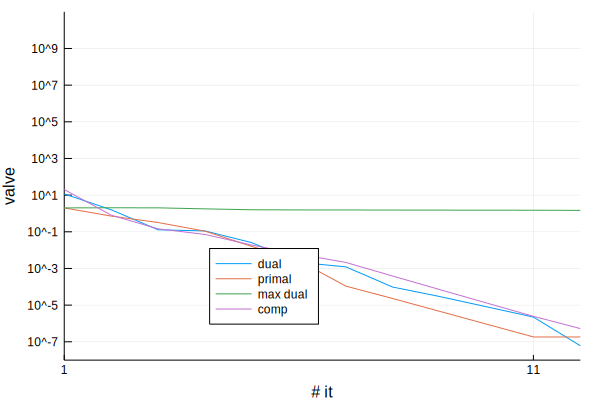

In [140]:
# plot the trajectory for one-phase
plot_trajectory(OP_hist_concise,min_y=10.0^(-8.0),max_y=10.0^(11.0))

In [9]:
################################################################
################################################################
######### CUTEst --- not working ###############################
################################################################
################################################################

In [398]:

using CUTEst

#nlp = CUTEstModel("HVYCRASH")
#nlp = CUTEstModel("JUNKTURN") # huge duals
#nlp = CUTEstModel("DISCS")
nlp  = CUTEstModel("SSNLBEAM")

Minimization problem SSNLBEAM
nvar = 3003, ncon = 2000 (1000 linear)


In [399]:
mp = NLPtoMPB(nlp, IpoptSolver(tol=1e-10));
status = MathProgBase.optimize!(mp)

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7998
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2002

Total number of variables............................:     3001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2000
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

0

In [400]:
NLP_IPOPT_hist = IPOPT_solver_history(nlp, 50; bound_relax_factor=0.0, tol=1e-10);

status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
status = -1
optimal_it = 50


50-element Array{OnePhase.generic_alg_history,1}:
 OnePhase.generic_alg_history(0, 349.664, 1249.71, 1.37184, 1.32481e-5, 1249.71, 4.62015)     
 OnePhase.generic_alg_history(1, 349.679, 120.933, 0.235398, 1.52662e-6, 120.933, 3.37775)    
 OnePhase.generic_alg_history(2, 349.825, 31.7202, 0.0468857, 5.62347e-6, 31.7202, 1.25026)   
 OnePhase.generic_alg_history(3, 348.544, 42.7448, 0.0072508, 1.37606e-6, 42.7448, 2.17696)   
 OnePhase.generic_alg_history(4, 347.698, 22.7345, 0.00181566, 8.09599e-7, 22.7345, 2.66207)  
 OnePhase.generic_alg_history(5, 346.993, 24.9933, 0.000678607, 9.55447e-7, 24.9933, 2.88391) 
 OnePhase.generic_alg_history(6, 346.976, 59.9177, 0.0112934, 4.32286e-9, 59.9177, 2.90691)   
 OnePhase.generic_alg_history(7, 346.74, 49.9362, 0.0025741, 6.46787e-8, 49.9362, 3.03934)    
 OnePhase.generic_alg_history(8, 346.634, 48.2755, 0.000714204, 1.22899e-8, 48.2755, 3.09281) 
 OnePhase.generic_alg_history(9, 346.319, 41.4289, 0.000152669, 1.15917e-7, 41.4289, 3.23239) 


In [402]:
iter, status, NLP_OP_hist, t, err, timer = OnePhase.one_phase_solve(nlp);
NLP_OP_hist_concise = OnePhase.major_its_only(NLP_OP_hist);

projecting onto bounds ...
(ais, bis) = (1:4000, 4001:8000)
(δ_s, δ_y, norm(g)) = (0.09892174806036517, 0.0, 0.47169542735673226)
it step  eta     α_P        α_D        ls |dx|       |dy|       N err      |mu         dual       primal     cmp scaled infeas?    |delta      #fac  |x|        |y|        ∇phi       phi        
0    i  2.17e-01   0.00e+00   0.00e+00   0 0.00e+00   0.00e+00   NaN        |2.17e-01   3.64e+00   3.69e-01   1.00e+00   Inf        |0.00e+00   0  0  5.00e-02   4.35e+00   2.15e+02   3.15751e+03
1    s  2.17e-01   3.09e-01   9.96e-01   1 2.45e-01   4.50e+00   1.28e-14   |2.17e-01   1.36e-02   3.69e-01   1.03e-01   Inf        |0.00e+00   1  1  3.49e-02   5.24e+00   1.08e+01   2.85817e+03
11   a  6.75e-04   2.31e-02   1.48e-01   1 8.93e-02   1.18e+03   2.42e-09   |6.75e-04   3.47e-05   1.15e-03   3.95e-02   1.70e+00   |0.00e+00   1  1  9.98e-01   2.09e+02   1.46e+02   2.20003e+02
21   s  3.57e-04   1.00e+00   9.16e-01   1 8.88e-02   3.65e+01   7.22e-10   |3.57e-04   1.9

In [397]:
finalize(nlp)

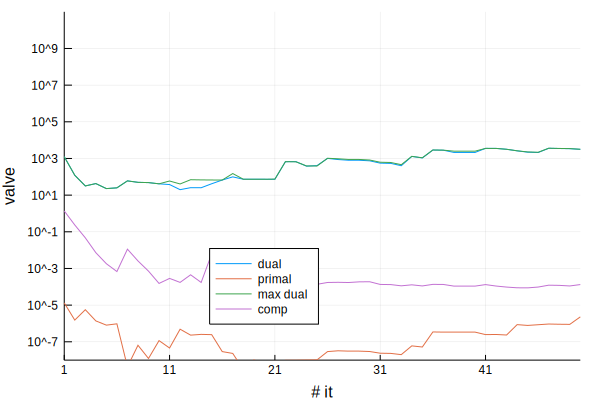

In [401]:
plot_trajectory(NLP_IPOPT_hist,min_y=10.0^(-8.0),max_y=10.0^(11.0))

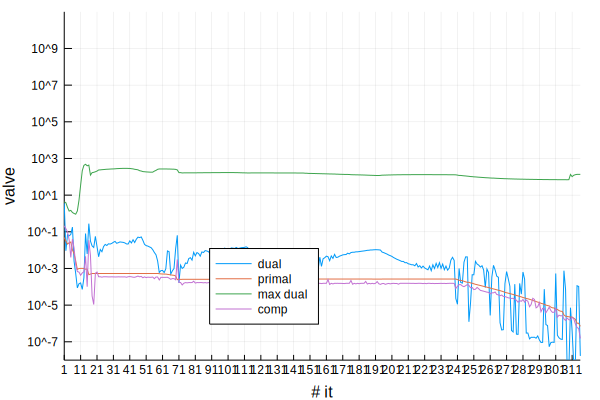

In [403]:
plot_trajectory(NLP_OP_hist_concise,min_y=10.0^(-8.0),max_y=10.0^(11.0))